In [1]:
import os, sys
from ZillowHouseData.logger import logger
from ZillowHouseData.exception import CustomException
import pandas as pd
import pickle

In [13]:
class DataPreprocessing:
    def __init__(self, file_name='ZILLOW_DATA_962c837a6ccefddddf190101e0bafdaf.csv', start_date='2012-01-01'):
        #self.file_name = file_name
        #self.file_name = os.path.join('../','artifacts', 'data_ingestion',file_name)
        self.file_name = os.path.join('..','artifacts', 'data_ingestion',file_name)
        self.start_date = start_date

    def data_preprocessing(self):
        dtypes = {
            'indicator_id': 'object',
            'region_id': 'int32',
            'value': 'float32',
            'date': 'object'
        }
        df_list = []
        count = 0

        #raw_data_path: str=os.path.join('artifacts/data_ingestion/','ZILLOW_DATA_962c837a6ccefddddf190101e0bafdaf.csv')
        print("\n printing os path current directory")
        print(os.getcwd())


        file_path = os.path.join('artifacts', 'data_ingestion', 'ZILLOW_DATA_962c837a6ccefddddf190101e0bafdaf.csv')
        print("\n printing file existance")
        print(os.path.exists(file_path))

        
        for chunk in pd.read_csv(self.file_name, chunksize=1000000,
                                 usecols=['indicator_id', 'region_id', 'date', 'value'],
                                 dtype=dtypes,
                                 parse_dates=['date']):
            filtered_chunk = chunk[(chunk['date'] >= self.start_date)]
            df_list.append(filtered_chunk)

        trimmed_df = pd.concat(df_list, ignore_index=True)

        del df_list
        
        trimmed_data = pickle.dumps(trimmed_df)
    
        return trimmed_data

    def get_year_month(self, data):
        trimmed_df = pickle.loads(data)
        trimmed_df['year'] = pd.to_datetime(trimmed_df['date']).dt.year
        trimmed_df['month'] = pd.to_datetime(trimmed_df['date']).dt.month
        trimmed_data = pickle.dumps(trimmed_df)
        return trimmed_data

    def get_stats(self, data):
        trimmed_df = pickle.loads(data)
        intersted_indicators_stats = ['IRAM', 'CRAM', 'MRAM', 'LRAM', 'NRAM', 'SRAM']
        stat_df = trimmed_df[trimmed_df['indicator_id'].isin(intersted_indicators_stats)]
        stat_pivot_df = stat_df.pivot_table(index=['region_id', 'year', 'month'], columns='indicator_id',
                                           values='value', aggfunc='mean')
        stat_pivot_df.reset_index(inplace=True)
        stat_pivot_df.dropna(inplace=True)
        stat_pivot_df.to_csv("stat.csv")
        del stat_df
        trimmed_data = pickle.dumps(trimmed_df)
        return trimmed_data

    def get_merge(self, data):
        trimmed_df = pickle.loads(data)
        df = pd.read_csv('stat.csv')
        intersted_indicators_ZHVI = ['ZATT', 'ZSFH', 'ZALL', 'ZCON', 'ZABT', 'Z2BR', 'Z5BR', 'Z3BR', 'Z1BR', 'Z4BR']
        ZHVI_df = trimmed_df[trimmed_df['indicator_id'].isin(intersted_indicators_ZHVI)]
        del trimmed_df
        final_df = pd.merge(ZHVI_df, df, on=['region_id', 'year', 'month'], how='inner')
        final_data = pickle.dumps(final_df)
        final_df.to_csv("final.csv")
        return final_data


In [7]:
from ZillowHouseData.components.data_preprocessing import DataPreprocessing
from ZillowHouseData.logger import logger
from ZillowHouseData.exception import CustomException
from ZillowHouseData.config.configuration import ConfigurationManager
from ZillowHouseData.pipeline.stage_01_data_ingestion_pipeline import ingestion_stage
import sys

In [14]:
STAGE_NAME = "Data Preprocessing stage"

class DataPreprocessingTrainingPipeline:
    def __init__(self):
        pass

    def main(self):
            # Create an instance of the DataPreprocessing class
            logger.info(f">>>>>> stage {STAGE_NAME} initated <<<<<<\n\nx==========x")
            data_preprocessor = DataPreprocessing()
            # Replace 'your_data_bytes_here' with the actual data bytes you want to process
            #data = b'your_data_bytes_here'
            # Stage 1: Data Preprocessing
            processed_data = data_preprocessor.data_preprocessing()
            # Stage 2: Extract Year and Month
            logger.info(f">>>>>> exact year & month <<<<<<\n\nx==========x")
            processed_data = data_preprocessor.get_year_month(processed_data)
            # Stage 3: Get Stats
            logger.info(f">>>>>> get stats <<<<<<\n\nx==========x")
            processed_data = data_preprocessor.get_stats(processed_data)
            # Stage 4: Merge Data
            logger.info(f">>>>>> merging data <<<<<<\n\nx==========x")
            final_data = data_preprocessor.get_merge(processed_data)
            print(final_data)



if __name__ == '__main__':
    #ingestion_stage()
    try:
        logger.info(f">>>>>> stage {STAGE_NAME} initated <<<<<<\n\nx==========x")
        obj1 = DataPreprocessingTrainingPipeline()
        obj1.main()
        logger.info(f">>>>>> stage {STAGE_NAME} completed <<<<<<\n\nx==========x")
    except Exception as e:
        logger.exception(e)
        raise CustomException(e,sys)
    


[2023-11-10 20:32:28,322: INFO: 1457263588: >>>>>> stage Data Preprocessing stage initated <<<<<<

x==========x]
[2023-11-10 20:32:28,323: INFO: 1457263588: >>>>>> stage Data Preprocessing stage initated <<<<<<

x==========x]

 printing os path current directory
/Users/keshavkumarelankovan/Desktop/ML_OPS/Skirmish/Zillow-data-ML-project/notebook

 printing file existance
False
[2023-11-10 20:32:28,325: ERROR: 1457263588: [Errno 2] No such file or directory: '. /artifacts/data_ingestion/ZILLOW_DATA_962c837a6ccefddddf190101e0bafdaf.csv']
Traceback (most recent call last):
  File "/var/folders/kp/6197l28d6yzb5wygdgr1hb7w0000gn/T/ipykernel_34285/1457263588.py", line 33, in <module>
    obj1.main()
  File "/var/folders/kp/6197l28d6yzb5wygdgr1hb7w0000gn/T/ipykernel_34285/1457263588.py", line 14, in main
    processed_data = data_preprocessor.data_preprocessing()
  File "/var/folders/kp/6197l28d6yzb5wygdgr1hb7w0000gn/T/ipykernel_34285/324563388.py", line 28, in data_preprocessing
    for chunk

CustomException: Error occured in python script name [/var/folders/kp/6197l28d6yzb5wygdgr1hb7w0000gn/T/ipykernel_34285/1457263588.py] line number [33] error message [[Errno 2] No such file or directory: '. /artifacts/data_ingestion/ZILLOW_DATA_962c837a6ccefddddf190101e0bafdaf.csv']

In [23]:
file_name = 'ZILLOW_DATA_962c837a6ccefddddf190101e0bafdaf.csv'
file = os.path.join('..','artifacts', 'data_ingestion',file_name)
print(os.path.exists(file))
print(os.getcwd())

True
/Users/keshavkumarelankovan/Desktop/ML_OPS/Skirmish/Zillow-data-ML-project/notebook


In [22]:
file_name = 'ZILLOW_DATA_962c837a6ccefddddf190101e0bafdaf.csv'
#script_dir = os.path.dirname(os.path.abspath(__file__))
script_dir = os.path.dirname(os.path.realpath(sys.argv[0]))
print(script_dir)
file_relative_path = os.path.join(script_dir, '..','artifacts', 'data_ingestion', file_name)

# Check if the file exists
print("File exists:", os.path.exists(file_relative_path))

# Print the current working directory
print("Current working directory:", os.getcwd())


/Users/keshavkumarelankovan/Desktop/ML_OPS/Skirmish/Zillow-data-ML-project/mlops_zillow/lib/python3.10/site-packages
File exists: False
Current working directory: /Users/keshavkumarelankovan/Desktop/ML_OPS/Skirmish/Zillow-data-ML-project/notebook


In [25]:
#os.chdir('../')

In [3]:
# !pip install -U scikit-learn
# !pip install pandas

from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Create a LabelEncoder instance
# label_encoder = LabelEncoder()
df = pd.read_csv('/Users/hm/Documents/Github_Projects/Zillow-data-ML-project/artifacts/data_ingestion/final.csv')
# Fit and transform the 'indicator_id' column
# df['indicator_id'] = label_encoder.fit_transform(df['indicator_id'])


In [4]:
df

,Unnamed: 0,indicator_id,region_id,date,value,year,month,CRAM,IRAM,LRAM,MRAM,NRAM,SRAM
0,0,ZATT,394521,2020-06-30,247142.0,2020,6,0.14970,2210.0,208990.0,25.0,4.0,158400.0
1,1,ZSFH,394521,2020-06-30,143910.0,2020,6,0.14970,2210.0,208990.0,25.0,4.0,158400.0
2,2,ZALL,394521,2020-06-30,142059.0,2020,6,0.14970,2210.0,208990.0,25.0,4.0,158400.0
3,3,ZCON,394521,2020-06-30,116574.0,2020,6,0.14970,2210.0,208990.0,25.0,4.0,158400.0
4,4,ZABT,394521,2020-06-30,77253.0,2020,6,0.14970,2210.0,208990.0,25.0,4.0,158400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
303915,303915,Z5BR,395237,2022-09-30,742851.0,2022,9,0.18595,228.0,226450.0,18.0,7.0,334000.0
303916,303916,Z2BR,395237,2022-09-30,334812.0,2022,9,0.18595,228.0,226450.0,18.0,7.0,334000.0
303917,303917,Z3BR,395237,2022-09-30,435978.0,2022,9,0.18595,228.0,226450.0,18.0,7.0,334000.0
303918,303918,Z1BR,395237,2022-09-30,388806.0,2022,9,0.18595,228.0,226450.0,18.0,7.0,334000.0


In [9]:
# from sklearn.preprocessing import LabelEncoder

# # Create a LabelEncoder instance
# label_encoder = LabelEncoder()
# df = pd.read_csv('/Users/hm/Documents/Github_Projects/Zillow-data-ML-project/artifacts/data_ingestion/final.csv')

# # Fit and transform the 'indicator_id' column
df['encoded_indicator_id'] = label_encoder.fit_transform(df['indicator_id'])

# Create a mapping dictionary to store the label-to-category mapping
label_to_category_mapping = dict(zip(df['encoded_indicator_id'], df['indicator_id']))

# Print the mapping
print(label_to_category_mapping)


{7: 'ZATT', 9: 'ZSFH', 6: 'ZALL', 8: 'ZCON', 5: 'ZABT', 4: 'Z5BR', 1: 'Z2BR', 2: 'Z3BR', 0: 'Z1BR', 3: 'Z4BR'}


In [24]:
df = pd.read_csv('/Users/hm/Documents/Github_Projects/Zillow-data-ML-project-1/artifacts/data_ingestion/final.csv')
label_encoder = LabelEncoder()
df['encoded_indicator_id'] = label_encoder.fit_transform(df['indicator_id'])
label_to_category_mapping = dict(zip(df['encoded_indicator_id'], df['indicator_id']))
label_to_category_mapping


{7: 'ZATT',
 9: 'ZSFH',
 6: 'ZALL',
 8: 'ZCON',
 5: 'ZABT',
 4: 'Z5BR',
 1: 'Z2BR',
 2: 'Z3BR',
 0: 'Z1BR',
 3: 'Z4BR'}

In [12]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('/Users/hm/Documents/Github_Projects/Zillow-data-ML-project-1/artifacts/data_ingestion/final.csv')
label_encoder = LabelEncoder()
df['encoded_indicator_id'] = label_encoder.fit_transform(df['indicator_id'])
label_to_category_mapping = dict(zip(df['encoded_indicator_id'], df['indicator_id']))
df.drop(['Unnamed: 0','indicator_id'], axis=1, inplace= True)

# Select relevant columns
columns_to_use = ['encoded_indicator_id', 'region_id', 'year', 'month', 'CRAM', 'IRAM', 'LRAM', 'MRAM', 'NRAM', 'SRAM']

# Define features and target variable
X = df[columns_to_use]
y = df['value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
label_to_category_mapping

{7: 'ZATT',
 9: 'ZSFH',
 6: 'ZALL',
 8: 'ZCON',
 5: 'ZABT',
 4: 'Z5BR',
 1: 'Z2BR',
 2: 'Z3BR',
 0: 'Z1BR',
 3: 'Z4BR'}

In [14]:
X_train

,encoded_indicator_id,region_id,year,month,CRAM,IRAM,LRAM,MRAM,NRAM,SRAM
194244,3,395229,2021,4,0.108794,1063.0,349000.0,21.0,5.0,290000.0
74223,2,395238,2018,8,0.252730,3776.0,299000.0,35.0,16.0,265000.0
244707,5,394353,2022,2,0.076923,229.0,279900.0,49.0,10.0,225000.0
213079,5,395063,2021,8,0.137255,131.0,250000.0,18.0,6.0,229000.0
188507,4,394910,2021,3,0.163148,2839.0,285000.0,32.0,8.0,239700.0
...,...,...,...,...,...,...,...,...,...,...
119879,4,394492,2019,9,0.316820,7164.0,249899.0,30.0,10.0,197500.0
259178,0,395033,2022,5,0.131169,726.0,175000.0,17.0,5.0,167000.0
131932,7,394875,2019,12,0.101535,1796.0,189900.0,80.0,44.0,153750.0
146867,4,395030,2020,4,0.159334,774.0,274900.0,33.0,13.0,229500.0


In [16]:
y_train

194244    428722.30
74223     278642.38
244707    177580.27
213079    130076.92
188507    451392.12
            ...    
119879    412963.03
259178     65765.00
131932    261069.38
146867    396993.97
121958    155938.75
Name: value, Length: 243136, dtype: float64

In [1]:
import pandas as pd
df = pd.read_csv('/Users/hm/Documents/Github_Projects/Zillow-data-ML-project-2/artifacts/data_ingestion/filter_df.csv')

In [ ]:
MLFLOW_TRACKING_URI=https://dagshub.com/MurariHarish/Zillow-data-ML-project.mlflow \
MLFLOW_TRACKING_USERNAME=MurariHarish \
MLFLOW_TRACKING_PASSWORD=3ee01b477e66e78b2b9353669d56356fc4d4138c \
python script.py

In [55]:
os.environ["MLFLOW_TRACKING_URI"]="https://dagshub.com/MurariHarish/Zillow-data-ML-project.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"]="MurariHarish"
os.environ["MLFLOW_TRACKING_PASSWORD"]="3ee01b477e66e78b2b9353669d56356fc4d4138c"

In [ ]:
export MLFLOW_TRACKING_URI=https://dagshub.com/MurariHarish/Zillow-data-ML-project.mlflow
export MLFLOW_TRACKING_USERNAME=MurariHarish
export MLFLOW_TRACKING_PASSWORD=3ee01b477e66e78b2b9353669d56356fc4d4138c


In [78]:
import pandas as pd
df = pd.read_csv('/Users/hm/Documents/Github_Projects/Zillow-data-ML-project-1/artifacts/data_ingestion/final.csv')

In [79]:
def calculate_min_max(df):
    """Calculates the min and max values for each column in the training data.

    Args:
        df (pandas.DataFrame): training data

    Returns:
        min_max_values (dict): min and max values for each column in the training data
    """
    min_max_values = df.agg(['min', 'max']).to_dict()
    return min_max_values

In [80]:
calculate_min_max(df)

{'Unnamed: 0': {'min': 0, 'max': 303919},
 'indicator_id': {'min': 'Z1BR', 'max': 'ZSFH'},
 'region_id': {'min': 102001, 'max': 845167},
 'date': {'min': '2018-01-31', 'max': '2023-07-31'},
 'value': {'min': 20075.06, 'max': 5441841.0},
 'year': {'min': 2018, 'max': 2023},
 'month': {'min': 1, 'max': 12},
 'CRAM': {'min': 0.0, 'max': 0.5},
 'IRAM': {'min': 48.0, 'max': 1733389.0},
 'LRAM': {'min': 44700.0, 'max': 2100000.0},
 'MRAM': {'min': 6.0, 'max': 324.0},
 'NRAM': {'min': 2.0, 'max': 324.0},
 'SRAM': {'min': 36000.0, 'max': 1690000.0}}

In [76]:
df = pd.read_csv('/Users/hm/Documents/Github_Projects/Zillow-data-ML-project-2/artifacts/data_ingestion/ZILLOW_DATA_962c837a6ccefddddf190101e0bafdaf.csv')

In [6]:
pd.read_csv('/Users/hm/Documents/Github_Projects/Zillow-data-ML-project-1/artifacts/data_ingestion/filter_df.csv').head()

,Unnamed: 0,indicator_id,region_id,date,value,year,month
0,265,Z4BR,66027,2022-07-31,472191.62,2022,7
1,558,Z4BR,97813,2022-07-31,2146551.00,2022,7
2,850,Z4BR,88825,2022-07-31,304682.34,2022,7
3,1141,Z4BR,95909,2022-07-31,469790.40,2022,7
4,1433,Z4BR,75872,2022-07-31,425064.44,2022,7


In [7]:
pd.read_csv('/Users/hm/Documents/Github_Projects/Zillow-data-ML-project-1/artifacts/data_ingestion/stats.csv').head()

,Unnamed: 0,region_id,year,month,CRAM,IRAM,LRAM,MRAM,NRAM,SRAM
0,72,102001,2018,1,0.147669,1491269.0,255000.0,54.0,47.0,225000.0
1,73,102001,2018,2,0.139205,1429228.0,264900.0,52.0,25.0,226000.0
2,74,102001,2018,3,0.153135,1421529.0,269900.0,48.0,20.0,232000.0
3,75,102001,2018,4,0.162306,1500194.0,279000.0,44.0,18.0,235500.0
4,76,102001,2018,5,0.185487,1592415.0,281000.0,43.0,18.0,240000.0


In [8]:
def get_merge(self, df_stats, df_month_year):
        try:
            interested_indicators_ZHVI = self.interested_indicators_zhvi
            ZHVI_df = df_month_year[df_month_year['indicator_id'].isin(interested_indicators_ZHVI)]
            
            final_df = pd.merge(ZHVI_df, df_stats, on=['region_id', 'year', 'month'], how='inner')
            final_df.to_csv(self.final_csv_path)
            logger.info(f">>>>>> Saved final.csv to {self.final_csv_path} <<<<<<\n\nx==========x")
            return final_df
        except Exception as e:
            raise CustomException(e,sys)
        
def test_get_merge():

    # Create test DataFrame for stats
    stats_data = {
    'region_id': [102001, 102001],
    'year': [2018, 2018],
    'month': [1, 2],
    'CRAM': [0.147669, 0.139205],
    'IRAM': [1491269.0, 1429228.0],
    'LRAM': [255000.0, 264900.0],
    'MRAM': [54.0, 52.0],
    'NRAM': [47.0, 25.0],
    'SRAM': [225000.0, 226000.0]
}

    stats_df = pd.DataFrame(stats_data)

    # Create test DataFrame for month_year
    month_year_data = {
    'region_id': [102001, 102001],
    'year': [2018, 2018],
    'month': [1, 2],
    'indicator_id': ['Z4BR', 'Z4BR'],
    'value': [472191.62, 2146551.00]
}

    month_year_df = pd.DataFrame(month_year_data)

    # Test get_merge
    merged_df = get_merge(stats_df, month_year_df)
    
    assert not merged_df.empty
    assert 'ZATT' in merged_df['indicator_id'].values
    assert 'CRAM' in merged_df.columns
    assert 'IRAM' in merged_df.columns




In [30]:
df_regions = pd.read_csv('/Users/hm/Documents/Github_Projects/Zillow-data-ML-project-1/artifacts/data_ingestion/ZILLOW_REGIONS_1a51d107db038a83ac171d604cb48d5b.csv')

In [32]:
df['region_id']

0         394521
1         394521
2         394521
3         394521
4         394521
           ...  
303915    395237
303916    395237
303917    395237
303918    395237
303919    395237
Name: region_id, Length: 303920, dtype: int64

In [31]:
df_regions.head()

,region_id,region_type,region
0,394401,metro,"Boone, IA; IA"
1,274772,neigh,Northeast Dallas; TX; Dallas-Fort Worth-Arling...
2,273698,neigh,"Far North; TX; Dallas-Fort Worth-Arlington, TX..."
3,275473,neigh,Southeast Dallas; TX; Dallas-Fort Worth-Arling...
4,196538,neigh,Murray Hill; NY; New York-Newark-Jersey City; ...


In [34]:
df_region_merge = pd.merge(df, df_regions, on='region_id', how='inner')

In [36]:
df_region_merge[df_region_merge['region_type'] == 'metro']

,Unnamed: 0,indicator_id,region_id,date,value,year,month,CRAM,IRAM,LRAM,MRAM,NRAM,SRAM,encoded_indicator_id,region_type,region
0,0,ZATT,394521,2020-06-30,247142.0,2020,6,0.14970,2210.0,208990.0,25.0,4.0,158400.0,7,metro,"Dayton, OH"
1,1,ZSFH,394521,2020-06-30,143910.0,2020,6,0.14970,2210.0,208990.0,25.0,4.0,158400.0,9,metro,"Dayton, OH"
2,2,ZALL,394521,2020-06-30,142059.0,2020,6,0.14970,2210.0,208990.0,25.0,4.0,158400.0,6,metro,"Dayton, OH"
3,3,ZCON,394521,2020-06-30,116574.0,2020,6,0.14970,2210.0,208990.0,25.0,4.0,158400.0,8,metro,"Dayton, OH"
4,4,ZABT,394521,2020-06-30,77253.0,2020,6,0.14970,2210.0,208990.0,25.0,4.0,158400.0,5,metro,"Dayton, OH"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303915,303915,Z5BR,395237,2022-09-30,742851.0,2022,9,0.18595,228.0,226450.0,18.0,7.0,334000.0,4,metro,"Wooster, OH"
303916,303916,Z2BR,395237,2022-09-30,334812.0,2022,9,0.18595,228.0,226450.0,18.0,7.0,334000.0,1,metro,"Wooster, OH"
303917,303917,Z3BR,395237,2022-09-30,435978.0,2022,9,0.18595,228.0,226450.0,18.0,7.0,334000.0,2,metro,"Wooster, OH"
303918,303918,Z1BR,395237,2022-09-30,388806.0,2022,9,0.18595,228.0,226450.0,18.0,7.0,334000.0,0,metro,"Wooster, OH"


In [48]:
df_region_merge[['region_id','region']]

,region_id,region
0,394521,"Dayton, OH"
1,394521,"Dayton, OH"
2,394521,"Dayton, OH"
3,394521,"Dayton, OH"
4,394521,"Dayton, OH"
...,...,...
303915,395237,"Wooster, OH"
303916,395237,"Wooster, OH"
303917,395237,"Wooster, OH"
303918,395237,"Wooster, OH"


In [52]:
df_regions = pd.read_csv('/Users/hm/Documents/Github_Projects/Zillow-data-ML-project-1/artifacts/data_ingestion/ZILLOW_REGIONS_1a51d107db038a83ac171d604cb48d5b.csv')
df_region_merge = pd.merge(df, df_regions, on='region_id', how='inner')
df_region_merge[['region_id','region']].drop_duplicates(subset=['region_id', 'region']).reset_index(drop=True)

,region_id,region
0,394521,"Dayton, OH"
1,394546,"Dunn, NC; NC"
2,395179,"Utica, NY"
3,394387,"Binghamton, NY"
4,394763,"Lake Charles, LA"
...,...,...
707,845158,"Dayton, OH"
708,845160,"Prescott Valley, AZ"
709,845164,"Lebanon, NH"
710,845167,"Ottawa, IL"


In [77]:
import pandas as pd

def extract_unique_regions(df):
    """
    Reads a CSV file, merges it with a given DataFrame on 'region_id',
    extracts and sorts unique 'region_id' and 'region', and returns a dictionary for region_id to region lookup.

    :param df: DataFrame to merge with the CSV data.
    :return: Dictionary for region_id to region lookup.
    """

    csv_path = '/Users/hm/Documents/Github_Projects/Zillow-data-ML-project-1/artifacts/data_ingestion/ZILLOW_REGIONS_1a51d107db038a83ac171d604cb48d5b.csv'

    # Read CSV file
    df_regions = pd.read_csv(csv_path)

    # Merge the provided DataFrame with the CSV data
    df_region_merge = pd.merge(df, df_regions, on='region_id', how='inner')

    # Extract unique 'region_id' and 'region', and reset the index
    unique_regions_df = df_region_merge[['region_id', 'region']].drop_duplicates(subset=['region_id', 'region'])

    # Sort the DataFrame based on 'region'
    sorted_unique_regions_df = unique_regions_df.sort_values(by='region').reset_index(drop=True)

    # Convert sorted DataFrame to dictionary for region_id to region lookup
    region_id_to_region = dict(zip(sorted_unique_regions_df['region_id'], sorted_unique_regions_df['region']))

    return region_id_to_region

# Usage example
# df is your original DataFrame
region_id_to_region = extract_unique_regions(df)


In [81]:
region_id_to_region[394521]

'Dayton, OH'

In [79]:
def load_pickle_object(load_folder, file_name):
    try:
        # Create the full load path, including the "artifacts/" folder
        load_path = os.path.join("artifacts", load_folder, file_name)

        # Load the model from the pickle file
        with open(load_path, 'rb') as file:
            loaded_model = pickle.load(file)

        return loaded_model

    except Exception as e:
        print(f"Error loading the model: {str(e)}")

def save_object_to_pickle(object_to_save, save_folder, file_name):
    try:
        # Create the full save path, including the "artifacts/" folder
        save_path = os.path.join("artifacts", save_folder, file_name)

        # Create the directory if it doesn't exist
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        # Save the trained model to a pickle file
        with open(save_path, 'wb') as file:
            pickle.dump(object_to_save, file)

        print(f"Model saved to {save_path}")
    except Exception as e:
        print(f"Error saving the model: {str(e)}")


In [ ]:
save_object_to_pickle(region_id_to_region, "models", 'region_label')

Model saved to artifacts/models/region_label


In [19]:
pip install tensorflow

  Using cached tensorflow-2.15.0-cp310-cp310-macosx_12_0_arm64.whl (2.1 kB)
  Using cached tensorflow_macos-2.15.0-cp310-cp310-macosx_12_0_arm64.whl (208.8 MB)
  Using cached numpy-1.26.2-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
  Using cached tensorflow_io_gcs_filesystem-0.34.0-cp310-cp310-macosx_12_0_arm64.whl (1.9 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 6.2 MB/s eta 0:00:00a 0:00:01
  Using cached absl_py-2.0.0-py3-none-any.whl (130 kB)
  Using cached libclang-16.0.6-py2.py3-none-macosx_11_0_arm64.whl (20.6 MB)
  Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl (441 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 32.7 MB/s eta 0:00:0000:0100:01
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 57.8 MB/s eta 0:00:0000:0100:01
  Using cached googl

In [70]:
#environment Imports
# import os, sys, pickle
# # from src.ZillowHouseData.logger import logger
# from src.ZillowHouseData.exception import CustomException
# # from sklearn.preprocessing import LabelEncoder
# from src.ZillowHouseData.utils.common import save_object_to_pickle
# from src.ZillowHouseData.entity.config_entity import ModelTrainingConfig

#model imports
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam

def build_model(input_shape):
            model = Sequential()
            model.add(Dense(128, activation='relu', input_shape=(input_shape,)))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
            model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
            model.add(BatchNormalization())
            model.add(Dropout(0.3))
            model.add(Dense(32, activation='relu', kernel_regularizer='l2'))
            model.add(BatchNormalization())
            model.add(Dropout(0.3))
            model.add(Dense(1, kernel_regularizer='l2'))

            # Compile the model
            model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

            return model

        
def train_model(model, X_train, y_train):

            params = {
                'learning_rate': 0.001,
                'epochs': 100,
                'batch_size': 32, 
                'validation_split': 0.1,
                'verbose': 2
            }

            # save_object_to_pickle(params, "models", "params.pkl")

            # Train the model
            history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=2)

            return model, history

In [33]:
model = build_model(X_train_scaled.shape[1])

In [34]:
model, history = train_model(model, X_train_scaled, y_train)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


6839/6839 - 8s - loss: 125352493056.0000 - val_loss: 120283635712.0000 - 8s/epoch - 1ms/step
Epoch 2/100
6839/6839 - 7s - loss: 121954803712.0000 - val_loss: 115303940096.0000 - 7s/epoch - 991us/step
Epoch 3/100
6839/6839 - 7s - loss: 116131233792.0000 - val_loss: 108553256960.0000 - 7s/epoch - 971us/step
Epoch 4/100
6839/6839 - 7s - loss: 108214755328.0000 - val_loss: 99541606400.0000 - 7s/epoch - 985us/step
Epoch 5/100
6839/6839 - 7s - loss: 98605686784.0000 - val_loss: 89167527936.0000 - 7s/epoch - 981us/step
Epoch 6/100
6839/6839 - 7s - loss: 87706861568.0000 - val_loss: 76625502208.0000 - 7s/epoch - 973us/step
Epoch 7/100
6839/6839 - 7s - loss: 76125659136.0000 - val_loss: 64769978368.0000 - 7s/epoch - 978us/step
Epoch 8/100
6839/6839 - 7s - loss: 64255250432.0000 - val_loss: 51646484480.0000 - 7s/epoch - 970us/step
Epoch 9/100
6839/6839 - 7s - loss: 52682514432.0000 - val_loss: 39497707520.0000 - 7s/epoch - 1ms/step
Epoch 10/100
6839/6839 - 7s - loss: 42113912832.0000 - val_loss:

In [71]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

def plot_actual_vs_forecasted(y_test, y_pred):
    plt.figure(figsize=(8, 4))
    plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='Forecasted')
    plt.title('Actual vs Forecasted Values')
    plt.ylabel('Value')
    plt.xlabel('Sample')
    plt.legend(loc='upper right')
    plt.show()



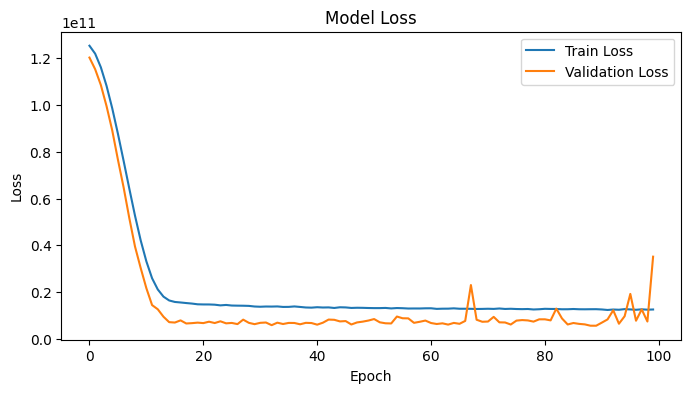

In [36]:
plot_loss(history)


In [72]:
import numpy as np
from sklearn.metrics import r2_score

def evaluate_model( model, X_test, y_test):
        # try:
            # Model summary logging
            model_details = model.summary()
            # logger.info(">>>>>> Model Summary <<<<<<\n\nx==========x")
            # logger.info(model_details)

            # Make predictions on the test set
            y_pred = model.predict(X_test)

            # Calculate and log metrics
            mse, rmse, r2 = calculate_metrics(y_test, y_pred)
            # self.log_metrics(mse, rmse, r2, model)

            return y_pred, mse, rmse, r2

        # except Exception as e:
        #     raise CustomException(e, sys)

def calculate_metrics( y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

In [73]:
model = build_model(X_train_scaled.shape[1])
model, history = train_model(model, X_train, y_train)
y_pred, mse, rmse, r2 = evaluate_model(model, X_test, y_test)

# Plotting
plot_loss(history)
plot_actual_vs_forecasted(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/data_adapter.py:1808: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
6839/6839 - 8s - loss: 125392568320.0000 - val_loss: 120415051776.0000 - 8s/epoch - 1ms/step
Epoch 2/100
6839/6839 - 7s - loss: 122172973056.0000 - val_loss: 117013635072.0000 - 7s/epoch - 987us/step
Epoch 3/100
6839/6839 - 7s - loss: 116734025728.0000 - val_loss: 109716938752.0000 - 7s/epoch - 969us/step
Epoch 4/100
6839/6839 - 7s - loss: 109380796416.0000 - val_loss: 101862883328.0000 - 7s/epoch - 954us/step
Epoch 5/100
6839/6839 - 7s - loss: 100409065472.0000 - val_loss: 91858100224.0000 - 7s/epoch - 967us/step
Epoch 6/100
6839/6839 - 7s - loss: 90395074560.0000 - val_loss: 82259623936.0000 - 7s/epoch - 965us/step
Epoch 7/100
6839/6839 - 7s - loss: 79637192704.0000 - val_loss: 159098945536.0000 - 7s/epoch - 995us/step
Epoch 8/100
6839/6839 - 7s - loss: 68830257152.0000 - val_loss: 60409937920.0000 - 7s/epoch - 1ms/step
Epoch 9/100
6839/6839 - 7s - loss: 58220113920.0000 - val_loss: 49001467904.0000 - 7s/epoch - 1ms/step
Epoch 10/100
6839/6839 - 7s - loss: 48860684288.000

KeyboardInterrupt: 

In [42]:
X_test_scaled

array([[ 0.17895575,  4.45472511,  0.84618632, ..., -1.29850173,
        -0.92649216, -0.430959  ],
       [-0.52010494,  4.45472511,  1.47690444, ..., -1.26054109,
        -0.97920756, -0.26307093],
       [ 1.57707714, -0.21382518,  0.84618632, ..., -0.99481659,
        -0.87377676,  0.18015359],
       ...,
       [ 1.22754679, -0.21239693,  0.84618632, ...,  0.75137298,
        -0.45205357,  1.44938742],
       [ 0.5284861 , -0.20978714,  0.2154682 , ..., -0.95685595,
        -0.76834596,  0.67710228],
       [-1.56869598, -0.20915093, -1.67668614, ...,  0.1440027 ,
        -0.03033039, -0.42760124]])

In [43]:
y_test

278515    132104.61
39033     295926.38
253014    292885.00
226918    293535.53
177475     84533.14
            ...    
218758    343800.34
117867    138517.38
269960    412995.03
225870    348839.38
82552     112635.89
Name: value, Length: 60784, dtype: float64

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               1408      
                                                                 
 batch_normalization_9 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_10 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 64)               

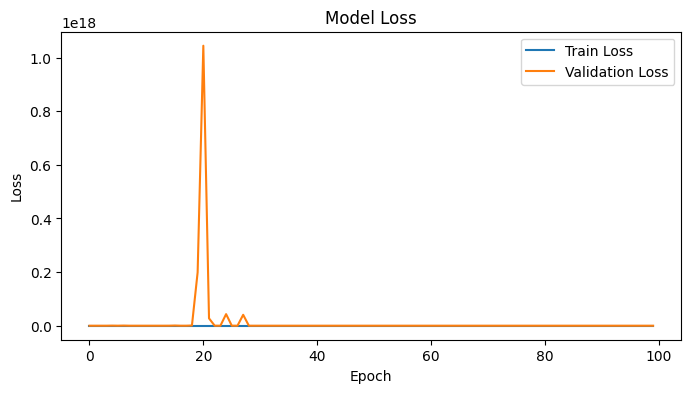

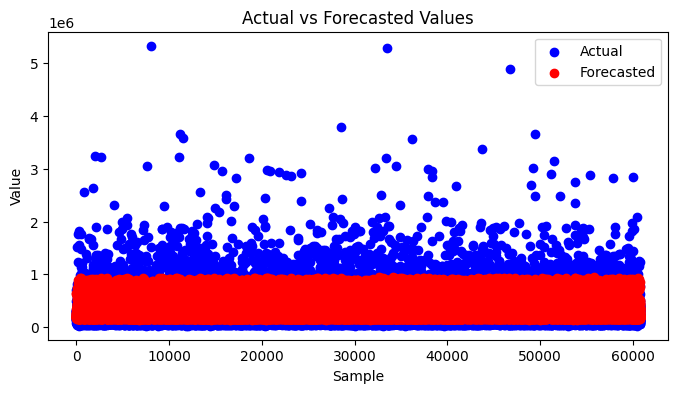

In [66]:
y_pred, mse, rmse, r2 = evaluate_model(model, X_test, y_test)

# Plotting
plot_loss(history)
plot_actual_vs_forecasted(y_test, y_pred)

In [67]:
import matplotlib.pyplot as plt

def plot_actual_vs_forecasted(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue', marker='o')
    plt.plot(y_pred, label='Forecasted', color='red', linestyle='--', marker='x')
    plt.title('Actual vs Forecasted Values')
    plt.ylabel('Value')
    plt.xlabel('Sample')
    plt.legend()
    plt.show()
